In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import sciunit
from owtests import OW_HOME
import wcon
import open_worm_analysis_toolbox as owat

In [2]:
OWAT_TESTS = os.path.join(OW_HOME,'tests','owtests','open-worm-analysis-toolbox')
mpl.rcParams.update({'font.size':16})

### Compute features from a Schafer-style data file

In [3]:
def get_schafer_features(file):
    # Load a "basic" worm from a file
    path = os.path.join(OW_HOME,'open-worm-analysis-toolbox','example_data',file)
    bw = owat.BasicWorm.from_schafer_file_factory(path)
    # Normalize the basic worm
    nw = owat.NormalizedWorm.from_BasicWorm_factory(bw)
    # Compute the features
    wf_experiment_schafer = owat.WormFeatures(nw)
    return wf_experiment_schafer

In [4]:
%time wf_experiment_schafer_1 = get_schafer_features('example_contour_and_skeleton_info.mat')

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


CPU times: user 47.7 s, sys: 656 ms, total: 48.3 s
Wall time: 48.7 s


In [5]:
# Doesn't work due to file structure issues
#%time wf_experiment_schafer_2 = get_schafer_features('example_video_norm_worm.mat')

### Compute features from a WCON-style data file

In [6]:
# A function to convert the WCON skeleton data into the format required for owat.BasicWorm 
def basic_worm_from_wcon(wcon_data):
    bw = owat.BasicWorm()
    data = wcon_data.data
    worm_name = data.columns.levels[0][0]
    skeleton_data = [data[worm_name].iloc[frame].unstack().iloc[1:].values for frame in range(data.shape[0])]
    bw._h_skeleton = skeleton_data
    return bw

In [7]:
def get_wcon_features(file):
    path = os.path.join(OWAT_TESTS,file)
    data = wcon.WCONWorms.load_from_file(path)
    bw = basic_worm_from_wcon(data)
    nw = owat.NormalizedWorm.from_BasicWorm_factory(bw)
    wf = owat.WormFeatures(nw)
    return wf

In [8]:
# Doesn't work due to formatting issues
#file = 'experiment/nca-1 (gk9) nca-2 (gk5) nRHO-1 QT309 on food L_2011_11_09__12_02___3___6.wcon'
#%time wf_experiment_wcon = get_wcon_features(file)

In [9]:
file = 'model/worm_motion_log.wcon'
%time wf_model_wcon = get_wcon_features(file)

Loading file: /Users/rgerkin/Dropbox/dev/openworm/tests/owtests/open-worm-analysis-toolbox/model/worm_motion_log.wcon


/Users/rgerkin/Dropbox (ASU)/dev/openworm/open-worm-analysis-toolbox/open_worm_analysis_toolbox/features/worm_features.py:815: UserWarning: morphology.width.head was NOT calculated. 'NormalizedWorm' object has no attribute 'widths'
  warnings.warn(msg_warn)
/Users/rgerkin/Dropbox (ASU)/dev/openworm/open-worm-analysis-toolbox/open_worm_analysis_toolbox/features/worm_features.py:815: UserWarning: morphology.width.midbody was NOT calculated. 'NormalizedWorm' object has no attribute 'widths'
  warnings.warn(msg_warn)
/Users/rgerkin/Dropbox (ASU)/dev/openworm/open-worm-analysis-toolbox/open_worm_analysis_toolbox/features/worm_features.py:815: UserWarning: morphology.width.tail was NOT calculated. 'NormalizedWorm' object has no attribute 'widths'
  warnings.warn(msg_warn)
/Users/rgerkin/Dropbox (ASU)/dev/openworm/open-worm-analysis-toolbox/open_worm_analysis_toolbox/features/worm_features.py:815: UserWarning: morphology.area was NOT calculated. 'NormalizedWorm' object has no attribute '_sign

CPU times: user 3min 40s, sys: 1.94 s, total: 3min 42s
Wall time: 3min 42s


In [12]:
features = list(wf_experiment_schafer_1._features.keys())
df = pd.DataFrame(index=features,columns=['wcon_model','wcon_experiment','schafer_experiment'])

def fill_df(wf,df,column):
    n_valid = 0
    for feature,value in wf._features.items():
        try:
            result = pd.Series(value.value).mean()
            if not np.isnan(result):
                df.loc[feature,column] = result
                #print(key,result)
                n_valid += 1
        except:
            pass
    print("%d valid features found for %s" % (n_valid,column))
    return df.astype('float')
    
df = fill_df(wf_model_wcon,df,'wcon_model')
#df = fill_df(wf_experiment_wcon,df,'wcon_experiment')
df = fill_df(wf_experiment_schafer_1,df,'schafer_experiment')
df.head()

48 valid features found for wcon_model
81 valid features found for schafer_experiment


,wcon_model,wcon_experiment,schafer_experiment
morphology.length,1.163448,NaN,966.907818
morphology.width.head,NaN,NaN,47.097449
morphology.width.midbody,NaN,NaN,85.879552
morphology.width.tail,NaN,NaN,47.009043
morphology.area,NaN,NaN,70229.892541


In [14]:
feature_name = 'posture.amplitude_ratio'
model_mean = pd.Series(wf_model_wcon.get_features(feature_name).value).mean()
experiment_mean = pd.Series(wf_experiment_schafer_1.get_features(feature_name).value).mean()
print(model_mean,experiment_mean)

0.5047637256663084 0.7644687430799605


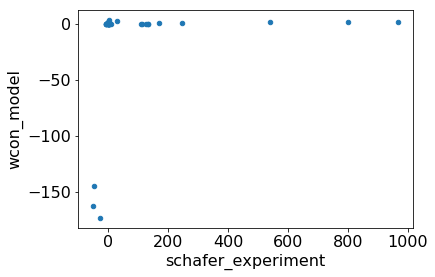

In [15]:
df.plot.scatter(x='schafer_experiment',y='wcon_model')

(-10, 10)

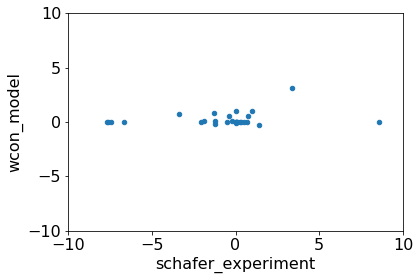

In [16]:
df.plot.scatter(x='schafer_experiment',y='wcon_model')
plt.xlim(-10,10)
plt.ylim(-10,10)